# Laboratorio III
## Unificación de datasets y Análisis Exploratorio

En este notebook se integrarán las diferentes fuentes de datos y se realizará un primer análisis exploratorio para entender la distribución de ventas (tn) y preparar el forecasting.

---

### 1. Importar librerías

Se importan las librerías necesarias para manipulación de datos y visualización.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

### 2. Carga de datos

- **`products`**: datos de catálogo de productos.
- **`stocks`**: stock final por producto y periodo.
- **`main`**: dataset principal de ventas por cliente/producto/periodo.

## 2.1 Descripción de columnas

Dataset **sell-in**

| Columna                  | Descripción                                                                                                                                                                                                 |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **periodo**              | Periodo en formato `AAAAMM` correspondiente al mes de la foto de ventas. Por ejemplo, `202504` incluye todas las ventas entre `2025-04-01 00:00:00` y `2025-04-30 23:59:59`.                               |
| **customer_id**          | Identificador único de cliente (~550 clientes: cadenas de supermercados, mayoristas, distribuidores). Puede haber clientes pequeños que no registren compras en un mes determinado.                            |
| **product_id**           | Identificador único del producto.                                                                                                                                                                             |
| **plan_precios_cuidados**| Indicador binario (`0` o `1`) de participación en el Plan Precios Cuidados impulsado por el gobierno.                                                                                                         |
| **cust_request_qty**     | Cantidad de cajas solicitadas por el cliente en el mes, neta de órdenes caídas. La unidad mínima de pedido es 1 caja, que puede contener distinto número de envases según el producto.                         |
| **cust_request_tn**      | Toneladas solicitadas, calculadas como `cust_request_qty` × peso en toneladas de una caja de ese producto.                                                                                                   |
| **tn**                   | Toneladas reales vendidas del producto a ese cliente en el periodo (campo principal para análisis).   


Dataset **tb_productos**

| Columna                  | Descripción                                                                                                                                                                                                 |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **cat1**              | Categoría principal del producto, Home care, Personal care o Food.                               |
| **cat2**          | Categoría de producto dentro de la categoría principal                            |
| **cat3**           | Subcategoría dentro de la categoría del producto.                                                                                                                                                           |
| **brand**         | Marca del producto.                                                                                                         |
| **sku_size**     |                      |
| **product_id**      | Identificador único del producto.                                                                                                    |


Dataset **tb_stocks**

| Columna                  | Descripción                                                                                                                                                                                                 |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **periodo**              | Periodo en formato `AAAAMM` correspondiente al mes de la foto de ventas. Por ejemplo, `202504` incluye todas las ventas entre `2025-04-01 00:00:00` y `2025-04-30 23:59:59`.                               |
| **product_id**          | Identificador único del producto.                            |
| **stock_final**           | La informacion de stocks indica cuanto stock de ese product_id quedaba a las 23:59:59 del ultimo dia del mes.                                                                                                                                                           |                                                                                                |


In [3]:
# Leer catálogo de productos
tb_productos = pd.read_csv('datasets/tb_productos.txt', sep='\t')
print(f"El dataset 'tb_productos' tiene {tb_productos.shape[0]} filas y {tb_productos.shape[1]} columnas")

# Leer stock final
tb_stocks = pd.read_csv('datasets/tb_stocks.txt', sep='\t')
print(f"El dataset 'tb_stocks' tiene {tb_stocks.shape[0]} filas y {tb_stocks.shape[1]} columnas")


# Leer dataset principal en chunks si es muy grande
chunks = pd.read_csv('datasets/sell-in.txt', sep='\t', chunksize=1_000_000)
sell_in = pd.concat(chunks)
print(f"El dataset 'sell_in' tiene {sell_in.shape[0]} filas y {sell_in.shape[1]} columnas")

El dataset 'tb_productos' tiene 1262 filas y 6 columnas
El dataset 'tb_stocks' tiene 13691 filas y 3 columnas
El dataset 'sell_in' tiene 2945818 filas y 7 columnas


### 3. Inspección inicial

Verificar estructura y valores faltantes.

In [25]:
sell_in.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [26]:
tb_productos.head()

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


In [27]:
sell_in.info()
sell_in.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945818 entries, 0 to 2945817
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   periodo                int64  
 1   customer_id            int64  
 2   product_id             int64  
 3   plan_precios_cuidados  int64  
 4   cust_request_qty       int64  
 5   cust_request_tn        float64
 6   tn                     float64
dtypes: float64(2), int64(5)
memory usage: 157.3 MB


periodo                  0
customer_id              0
product_id               0
plan_precios_cuidados    0
cust_request_qty         0
cust_request_tn          0
tn                       0
dtype: int64

In [28]:
num_dup_rows = sell_in.duplicated().sum()
print(f"Filas duplicadas en sell_in: {num_dup_rows}")

Filas duplicadas en sell_in: 0


In [29]:
tb_productos.head()

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


In [30]:
tb_productos.info()
tb_productos.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cat1        1262 non-null   object
 1   cat2        1262 non-null   object
 2   cat3        1262 non-null   object
 3   brand       1262 non-null   object
 4   sku_size    1262 non-null   int64 
 5   product_id  1262 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 59.3+ KB


cat1          0
cat2          0
cat3          0
brand         0
sku_size      0
product_id    0
dtype: int64

In [31]:
num_dup_rows = tb_productos.duplicated().sum()
print(f"Filas duplicadas en tb_productos: {num_dup_rows}")

Filas duplicadas en tb_productos: 9


In [32]:
# Eliminar duplicados 
tb_productos.drop_duplicates(inplace=True)

In [33]:
num_dup_rows = tb_productos.duplicated().sum()
print(f"Filas duplicadas en tb_productos: {num_dup_rows}")

Filas duplicadas en tb_productos: 0


In [34]:
# Agrupar por product_id y contar registros, ordenando de forma descendente
conteo_productos = tb_productos.groupby('product_id').size().sort_values(ascending=False)
print("Cantidad de registros por product_id en tb_productos (orden descendente):")
display(conteo_productos.head(10))  # muestra los 10 con más repeticiones

Cantidad de registros por product_id en tb_productos (orden descendente):


product_id
20623    2
20230    2
20001    1
20836    1
20843    1
20842    1
20841    1
20840    1
20839    1
20838    1
dtype: int64

In [35]:
tb_productos[tb_productos['product_id'].isin(values=[20623, 20230])]

,cat1,cat2,cat3,brand,sku_size,product_id
915,PC,CABELLO,ACONDICIONADOR,SHAMPOO3,350,20623
917,PC,CABELLO,ACONDICIONADOR,SHAMPOO3,350,20230
981,PC,CABELLO,SHAMPOO,SHAMPOO3,350,20623
983,PC,CABELLO,SHAMPOO,SHAMPOO3,350,20230


Los productos con PRODUCT_ID 20623 y 20230 figuran tanto como SHAMPOO como ACONDICIONADOR por lo que en ese caso hay que tomar alguna decisión cual se elimina y cual se conserva para no duplicar datos de las ventas al reunir los datos.

In [4]:
tb_productos_clean = (
    tb_productos.groupby('product_id')
    .agg({
        'cat1': 'first',
        'cat2': 'first',
        'cat3': lambda x: ','.join(sorted(set(x))),
        'brand': 'first',
        'sku_size': 'first'
    })
    .reset_index()
)
tb_productos_clean[tb_productos_clean['product_id'].isin(values=[20623, 20230])]

,product_id,cat1,cat2,cat3,brand,sku_size
229,20230,PC,CABELLO,"ACONDICIONADOR,SHAMPOO",SHAMPOO3,350
620,20623,PC,CABELLO,"ACONDICIONADOR,SHAMPOO",SHAMPOO3,350


In [37]:
tb_stocks.head()

,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595


In [38]:
tb_stocks.info()
tb_stocks.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13691 entries, 0 to 13690
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   periodo      13691 non-null  int64  
 1   product_id   13691 non-null  int64  
 2   stock_final  13691 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 321.0 KB


periodo        0
product_id     0
stock_final    0
dtype: int64

In [39]:
num_dup_rows = tb_stocks.duplicated().sum()
print(f"Filas duplicadas en tb_stocks: {num_dup_rows}")

Filas duplicadas en tb_stocks: 0


### 4. Unificación de tablas

Se unen las tablas con **`product_id`** y **`periodo`**.

In [40]:
# Merge con catálogo de productos
df = sell_in.merge(tb_productos, on='product_id', how='left')
assert df.shape[0] == sell_in.shape[0], f"Merge con productos duplicó filas: {df.shape[0]} vs {sell_in.shape[0]}"

# # Merge con stock final
# df = sell_in.merge(tb_stocks, on=['periodo', 'product_id'], how='left')
# assert df.shape[0] == sell_in.shape[0], f"Merge con stocks duplicó filas: {df.shape[0]} vs {sell_in.shape[0]}"

# print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas")

AssertionError: Merge con productos duplicó filas: 2951443 vs 2945818

Detectamos duplicados en tb_productos, 1 product id tiene asociado dos cat3 distintas haciendo que genere duplicados. Hicimos una limpieza y conservamos ambas cat3 separado por ",", ahora utilizaremos **tb_productos_clean** para joinear.

In [5]:
# Merge con catálogo de productos
df = sell_in.merge(tb_productos_clean, on='product_id', how='left')
assert df.shape[0] == sell_in.shape[0], f"Merge con productos duplicó filas: {df.shape[0]} vs {sell_in.shape[0]}"

# Merge con stock final
df = df.merge(tb_stocks, on=['periodo', 'product_id'], how='left')
assert df.shape[0] == sell_in.shape[0], f"Merge con stocks duplicó filas: {df.shape[0]} vs {sell_in.shape[0]}"

print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas")

El dataset tiene 2945818 filas y 13 columnas


In [6]:
df['periodo'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m').dt.strftime('%Y-%m')

In [46]:
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,stock_final
0,2017-01,10234,20524,0,2,0.05300,0.05300,HC,VAJILLA,Cristalino,Importado,500.0,NaN
1,2017-01,10032,20524,0,1,0.13628,0.13628,HC,VAJILLA,Cristalino,Importado,500.0,NaN
2,2017-01,10217,20524,0,1,0.03028,0.03028,HC,VAJILLA,Cristalino,Importado,500.0,NaN
3,2017-01,10125,20524,0,1,0.02271,0.02271,HC,VAJILLA,Cristalino,Importado,500.0,NaN
4,2017-01,10012,20524,0,11,1.54452,1.54452,HC,VAJILLA,Cristalino,Importado,500.0,NaN


### 5. Análisis descriptivo

- Estadísticas generales con `describe()`
- Series temporales por categoría y marca

In [47]:
# Estadísticas básicas
df.describe()

,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,sku_size,stock_final
count,2.945818e+06,2.945818e+06,2.945818e+06,2.945818e+06,2.945818e+06,2.945818e+06,2.938370e+06,1.131517e+06
mean,1.017148e+04,2.042787e+04,1.155163e-02,2.148753e+00,4.593203e-01,4.497863e-01,4.468480e+02,2.636688e+01
std,1.421467e+02,3.124612e+02,1.068559e-01,3.571552e+00,3.222836e+00,3.108355e+00,7.456050e+02,7.416614e+01
min,1.000100e+04,2.000100e+04,0.000000e+00,1.000000e+00,1.000000e-04,1.000000e-04,1.000000e+00,-2.731136e+01
25%,1.005300e+04,2.016100e+04,0.000000e+00,1.000000e+00,1.029000e-02,1.027000e-02,9.000000e+01,1.740740e+00
50%,1.013300e+04,2.036600e+04,0.000000e+00,1.000000e+00,3.931000e-02,3.931000e-02,2.400000e+02,7.045000e+00
75%,1.026700e+04,2.065400e+04,0.000000e+00,2.000000e+00,1.572500e-01,1.572500e-01,4.500000e+02,2.237392e+01
max,1.063700e+04,2.129900e+04,1.000000e+00,9.200000e+01,5.515614e+02,5.478785e+02,1.000000e+04,1.562024e+03


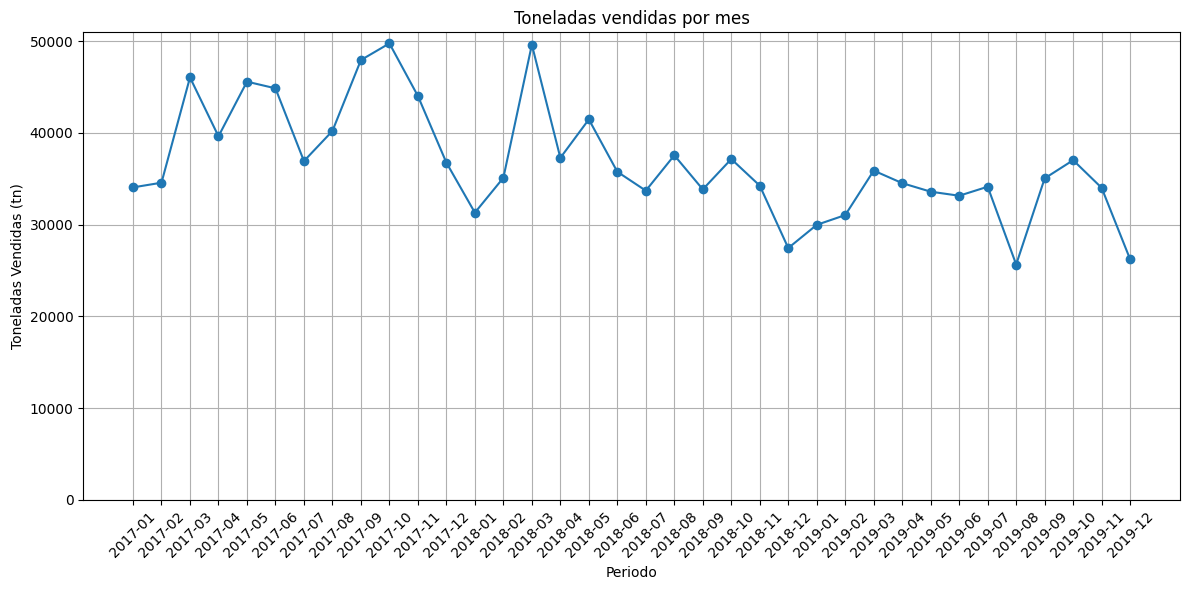

In [57]:
# Ventas por mes
time_series = df.groupby('periodo')['tn'].sum().reset_index()
plt.figure(figsize=(12, 6))  # ampliar tamaño de figura
plt.plot(
    time_series['periodo'], 
    time_series['tn'],
    marker='o',        # marcador tipo círculo en cada punto
    linestyle='-'      # línea continua (opcional, es el default)
)
plt.title('Toneladas vendidas por mes')
plt.xlabel('Periodo')
plt.ylabel('Toneladas Vendidas (tn)')
plt.xticks(rotation=45)
plt.ylim(bottom=0) 
plt.grid(True) 
plt.tight_layout() 
plt.show()

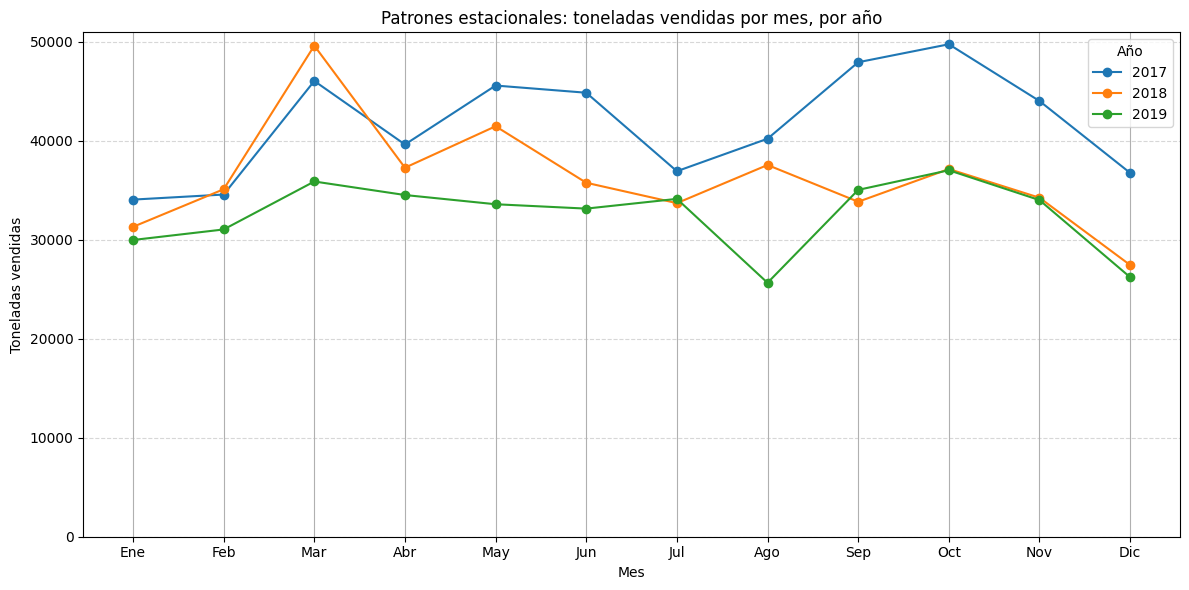

In [66]:
# Asegurate de que 'periodo' esté en datetime
df['date'] = pd.to_datetime(df['periodo'], format='%Y-%m')
df['year']  = df['date'].dt.year
df['month'] = df['date'].dt.month

# Agrego nombres de mes opcionalmente
meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']

# Agrego la suma de tn por año y mes
seasonal = (
    df
    .groupby(['year','month'])['tn']
    .sum()
    .reset_index()
    .pivot(index='month', columns='year', values='tn')
    .sort_index()
)

plt.figure(figsize=(12,6))
for año in seasonal.columns:
    plt.plot(seasonal.index,
             seasonal[año],
             marker='o',
             label=str(año))

plt.xticks(ticks=range(1,13), labels=meses)
plt.title('Patrones estacionales: toneladas vendidas por mes, por año')
plt.xlabel('Mes')
plt.ylabel('Toneladas vendidas')
plt.legend(title='Año')
plt.ylim(bottom=0) 
plt.grid(True)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Patrón estacional**

Picos fuertes cada año en torno a los meses de marzo/abril y octubre, y valles en enero/febrero y diciembre. Esto sugiere que podria existir un ciclo estacional bimodal (quizás relacionado con compras pre–temporada de verano e invierno). Ademas, si comparamos enero con febrero, en todos los años febrero presenta un aumento respecto a enero. Sin embargo, el dato de febrero no es en todos los años mayor que el de diciembre.

**Variabilidad interanual:**

Aunque el patrón de picos/valles se repite, la altura de esos picos va cambiando de un año al otro. Por ejemplo, el pico de octubre 2017 (~50 000 tn) es más alto que el de octubre 2018 o 2019 (~37 000–38 000 tn).

**Tendencia ligera:**

A simple vista parece que después de 2017 las ventas máximas han bajado un poco y la “base” de las mínimas crece o se estabiliza, indicando quizá una madurez del negocio o cambios en mix de productos. Tendencia a la baja.

**Caida agosto 2019**

- El domingo 11 de agosto de 2019 el entonces presidente Mauricio Macri pierde por 15 puntos las elecciones PASO ante el candidato Alberto Fernandez (quien meses mas tarde sería elegido presidente)
- El lunes 12 de agosto de 2019 el dólar blue que había cerrado el viernes a $ 46.90, salta el precio a $ 57.00, y el miercoles 14 llegó a los $ 62.00
- La Multinacional decide dejar de vender hasta poder establecer una lista de precios que permita cubrir sus costos, ya que muchos insumos son importados
- La Multinacional pasa 10 dias sin vender ningun producto
- Al dia 11, vuelve a vender
- El mes de 201908 fue el mes de ventas más bajas de esa década. En esa epoca fue cuando se contacta la consultora para realizar el proyecto.

**Caida enero 2018**

Bajas ventas pero no esta relacionado con lo sucedido en agosto 2019

**Cambio de tendencia a partir de mediados de 2018**

Hasta octubre 2017 (casi 50 000 tn) los picos eran muy altos, pero después de marzo 2018 el máximo anual baja y en 2019 ya no vuelve a acercarse a esos 50 000 tn: los picos de marzo 2018 (~49 500) y octubre 2018 (~37 000) están por debajo de los de 2017, y en 2019 los picos de marzo/octubre rondan 35–37 000 tn. Eso sugiere un declive estructural o cambio de mix/producto a mitad de 2018.

**Variación en la profundidad de los valles invernales**

Enero 2018 cae a ~31 000 tn, más bajo que enero 2017 (~34 000) y también más pronunciado que enero 2019 (~27 000). Esto implica que la “crisis” de temporada fuerte en verano (verano austral) se fue agudizando en 2018, luego se recupera algo en 2019, pero nunca vuelve a los niveles de 2017.

**Mayor homogeneidad en 2019**

En 2019 las ventas fluctúan en un rango más estrecho (aprox. 25 000–37 000 tn) frente al rango más amplio de 2017–2018 (31 000–50 000). Esto podría indicar que la empresa estabilizó su portafolio, reduciendo volatilidad de lanzamientos/promociones.

**A tener en cuenta al crear features:**
- delta dolar
- delta de la inflacion
- periodo electoral
- Tendencia lineal o polinómica: un feature trend = número de mes desde inicio para capturar el declive general.
- Dummy de “post-break”: un indicador que tome valor 1 a partir de abril 2018 (o el mes donde ves el quiebre) para que el modelo ajuste una tendencia distinta antes y después.
- Volatilidad estacional variable: podrías medir el “rango” mensual año a año y usarlo como feature de incertidumbre; por ejemplo, un rolling-std de tn sobre los 12 meses anteriores.
- Interacción tendencia × mes: para reflejar que la estacionalidad (la altura de picos/valles) cambia a lo largo de los años.
- Valles regulares en enero–febrero y diciembre
- Picos marcados en marzo/abril y octubre

### Cuantos clientes representan el mayor % de ventas

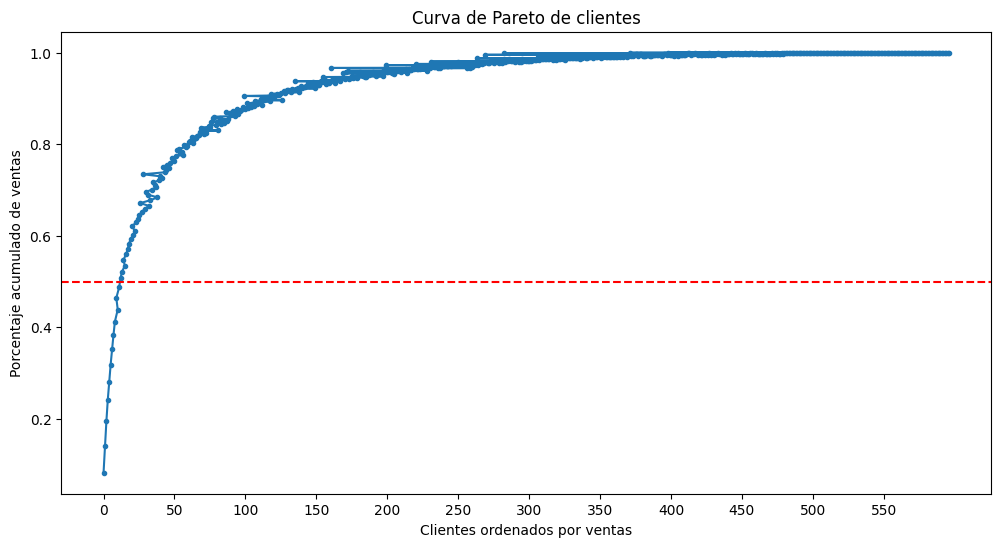

In [62]:
ventas_cliente = df.groupby('customer_id')['tn'].sum().reset_index().sort_values('tn', ascending=False)
ventas_cliente['porcentaje'] = ventas_cliente['tn'].cumsum() / ventas_cliente['tn'].sum()

plt.figure(figsize=(12,6))
plt.plot(ventas_cliente.index, ventas_cliente['porcentaje'], marker='.')
plt.axhline(0.5, color='r', linestyle='--')
plt.title('Curva de Pareto de clientes')
plt.xlabel('Clientes ordenados por ventas')
plt.ylabel('Porcentaje acumulado de ventas')

# Eje X de a 50 clientes
step = 50
plt.xticks(
    range(0, len(ventas_cliente), step),
    [str(i) for i in range(0, len(ventas_cliente), step)]
)

plt.show()

Este grafico muestra el porcentaje acumulado de ventas (eje Y) a medida que se va incluyendo clientes ordenados de mayor a menor volumen (eje X).

**Observaciones:**

- Alta concentración inicial

La curva sube muy rápido en los primeros ~10–15 clientes, alcanzando justo el 50 % de las ventas con ese grupo pequeño. Eso confirma que, efectivamente, un grupo reducido de clientes explica la mitad de las ventas.

- Efecto “cola larga”

Después de esos primeros clientes, la pendiente se va aplanando: cada nuevo cliente aporta cada vez menos al acumulado. Hacia los 200–300 clientes ya estás por encima del 80–90 % de las ventas, pero se necesitan sumar muchos más para llegar al 100 %.

- Implicaciones para el modelado

    - Segmentación: Podría tener sentido modelar distinto para los “top 13” (clientes clave) y para el resto (“cola larga”), porque sus patrones de compra y estacionalidad pueden diferir mucho.

    - Reducción de dimensión: Quizá agrupar clientes muy pequeños en un bucket “otros” o trabajar a nivel de categoría en lugar de “cliente × producto” para esa cola mejora la estabilidad de tu modelo.

    - Recursos: Enfocar más esfuerzo de forecast y monitoreo en esos clientes top, donde el impacto de un error de forecast es mayor.

En resumen, la curva confirma un patrón muy concentrado: unos pocos clientes dominan el volumen, y la mayoría aporta muy poco de forma individual. Eso te ayudará a decidir cómo particionar tus datos, qué nivel de granularidad usar y dónde aplicar técnicas de agregación o shrinkage para el tail.

### 6. Análisis por segmento

- Comparar ventas Homecare vs Personalcare vs Foods
- Impacto del Plan Precios Cuidados

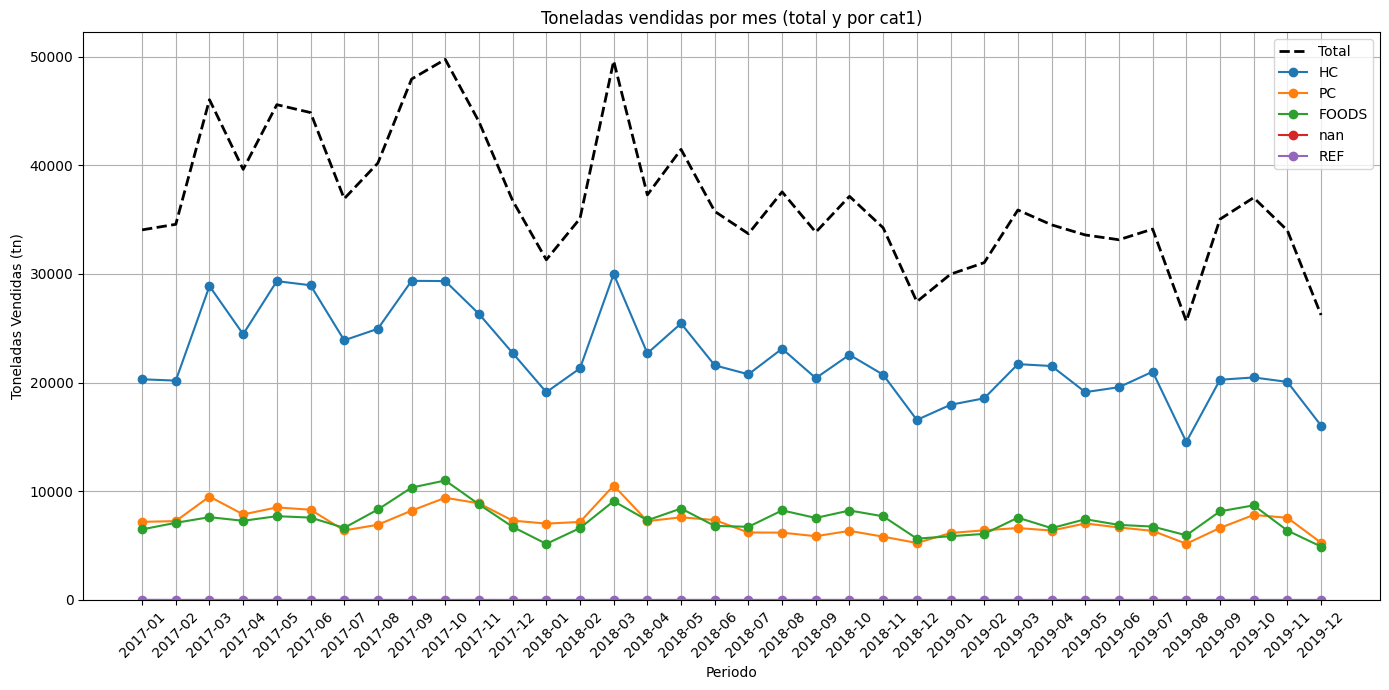

In [59]:
plt.figure(figsize=(14, 7))

# 1️⃣ Línea total
total_por_periodo = df.groupby('periodo')['tn'].sum().reset_index()
plt.plot(
    total_por_periodo['periodo'],
    total_por_periodo['tn'],
    color='black',
    linestyle='--',
    linewidth=2,
    label='Total'
)

# 2️⃣ Líneas por cada cat1
for categoria in df['cat1'].unique():
    cat_data = df[df['cat1'] == categoria]
    cat_por_periodo = cat_data.groupby('periodo')['tn'].sum().reset_index()
    plt.plot(
        cat_por_periodo['periodo'],
        cat_por_periodo['tn'],
        marker='o',
        label=categoria
    )

plt.title('Toneladas vendidas por mes (total y por cat1)')
plt.xlabel('Periodo')
plt.ylabel('Toneladas Vendidas (tn)')
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Dominio de Home Care (HC)**

La línea azul (HC) está siempre muy por encima de las otras categorías, contribuyendo de un 50–60 % del total cada mes.

**Razón de categorías pequeñas**

Personal Care (PC, naranja) y Foods (verde) se mantienen cada una en torno al 15–25 % del total, con patrones estacionales similares —sus picos coinciden con los del total, pero en menor escala.

**Consistencia de mix**

Aunque varíe el volumén total, la proporción entre HC, PC y Foods es bastante estable mes a mes (no ves meses donde, por ejemplo, PC de repente duplique su participación).

¿Qué aprendemos?

Modelar por cat1: Dado que cada categoría tiene su propio nivel y estacionalidad (aunque el timing de los picos es parecido), conviene incluir dummies o series separadas por cat1 para capturar esas diferencias de escala.

Estacionalidad global vs. particular: Los picos globales se reproducen en cada categoría, lo que sugiere que hay factores que afectan a todo el portafolio (p. ej. pautas de compra estacionales de la cadena de supermercados) más un “offset” propio de cada categoría.

Sin “ruido” de categorías menores: Al no haber otros valores en cat1, tu modelado no va a distraerse con categorías esporádicas; podrías agrupar PC y Foods en un solo modelo o tratarlas por separado según la granularidad que busques.

Con estos insights podés:

Crear features de estacionalidad comunes (mes, trimestre) + interacciones con cat1.

Ajustar modelos jerárquicos (forecast total → desagregar por cat1, o modelar cada cat1 por separado).

Validar la proporcion de participacion por cliente y product id, podria ayudarme a entender si tiene sentido modelar distinto para los top x de clientes claves y para el restante, ya que los patrones de compra pueden variar. 

También me ayudaria a entender si agrupar clientes pequeños en un bucket “otros” o trabajar a nivel de categoría en lugar de “cliente × producto”  es mas util para modelar. 

#### Cross-correlation

Método sencillo para cuantificar leads/lags. Calcula, para cada par de series, las correlaciones desplazando una contra la otra ±k meses.

In [68]:
from statsmodels.tsa.stattools import ccf

# Prepara la serie mensual por categoría
seasonal = (df
    .groupby(['year','month','cat1'])['tn']
    .sum()
    .reset_index()
    .pivot_table(index=['year','month'], columns='cat1', values='tn')
    .sort_index()
)
hc = seasonal['HC']
pc = seasonal['PC']
f  = seasonal['FOODS']

# Función para corr desplazada
def cross_corr(s1, s2, lag):
    return s1.corr(s2.shift(lag))

lags = range(-3, 4)
results = []
for lag in lags:
    results.append({
        'lag (s2 shift)': lag,
        'corr HC vs PC': cross_corr(hc, pc, lag),
        'corr HC vs FOODS': cross_corr(hc, f, lag),
        'corr PC vs FOODS': cross_corr(pc, f, lag),
    })
corr_df = pd.DataFrame(results).set_index('lag (s2 shift)')
corr_df


,corr HC vs PC,corr HC vs FOODS,corr PC vs FOODS
lag (s2 shift),,,
-3,0.236946,0.174152,0.008609
-2,0.185464,0.152476,-0.024965
-1,0.389665,0.317987,0.100457
0,0.836221,0.743707,0.626658
1,0.419252,0.369219,0.357725
2,0.371476,-0.032457,-0.062203
3,0.307747,-0.133385,-0.098225


La máxima correlación entre cada par de categorías ocurre en lag = 0, por lo que no hay un adelanto o retraso significativo, todas las categorías suben y bajan exactamente al mismo tiempo.

HACERRRR


la cat1 tiene un peso tan grande que casi tiene la misma distribucion que el total de la base
comportamiento ciclico (en diciembre)
armar mismo grafico en % sin la cantidad tn total --> no se espera ver caida sino la proporcion
La distribucion de food adelanta que pasa


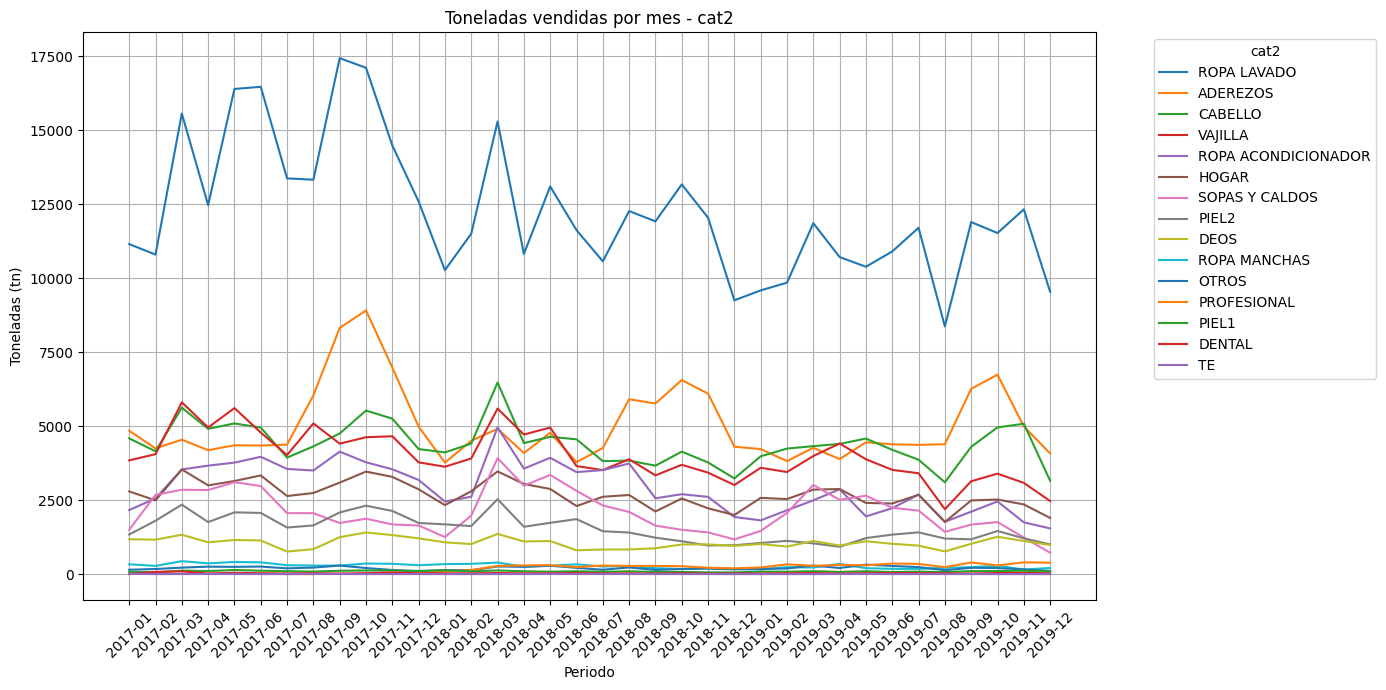

In [26]:
plot_tn_by_category(df, 'cat2')

/Users/indianaabeledo/Documents/Maestria/laboratorio_III/utils.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


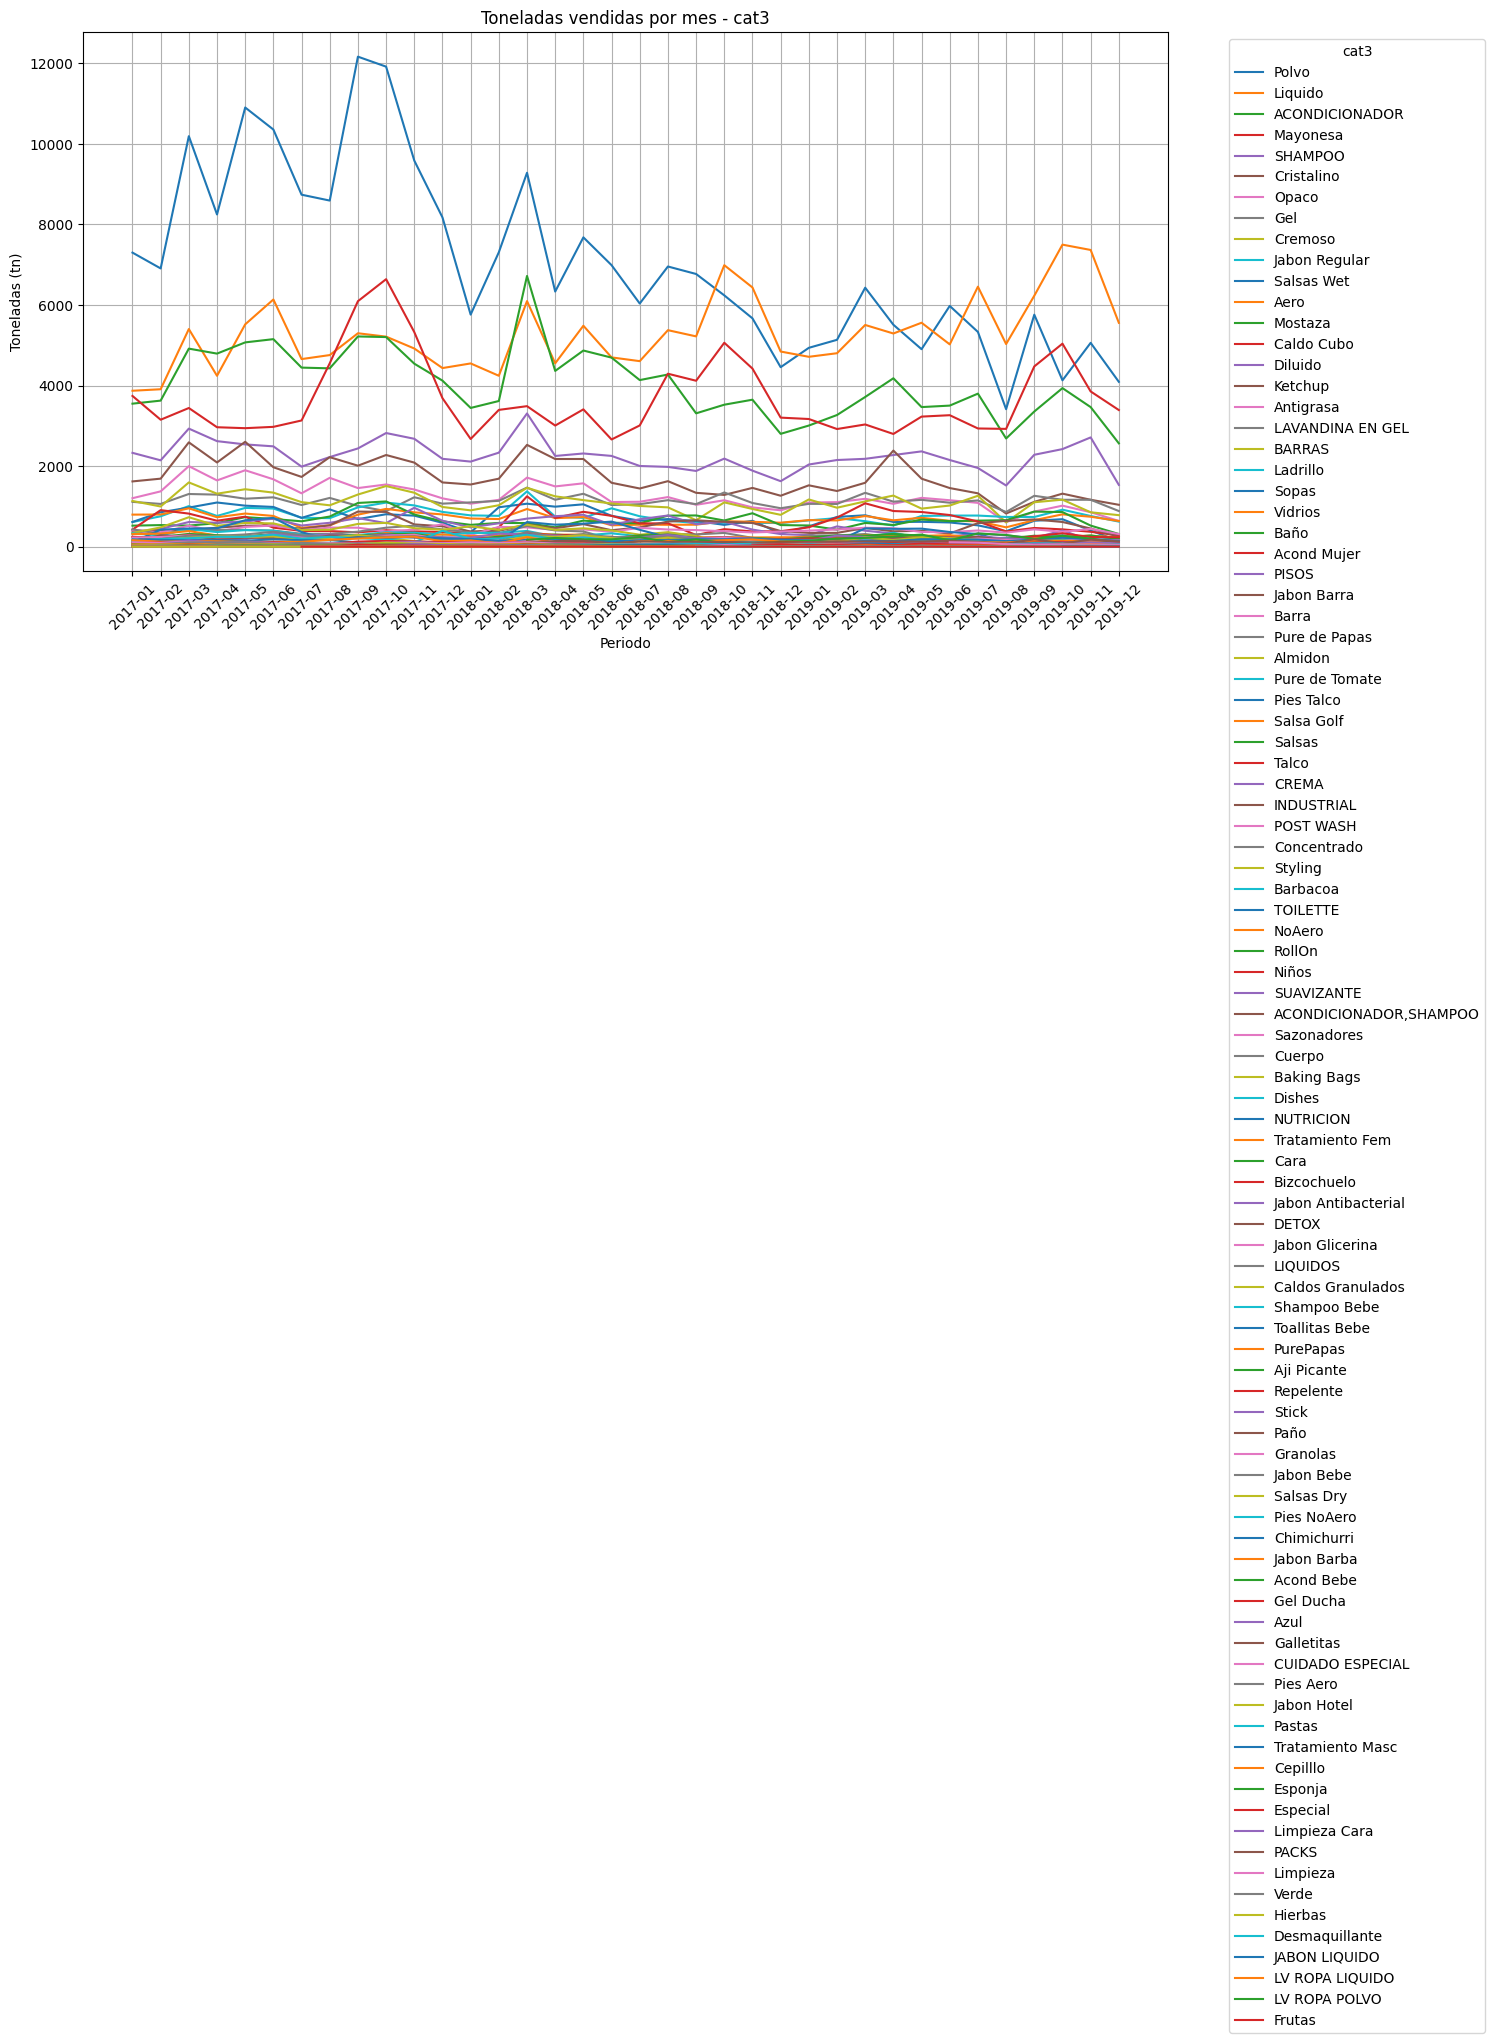

In [27]:
plot_tn_by_category(df, 'cat3')

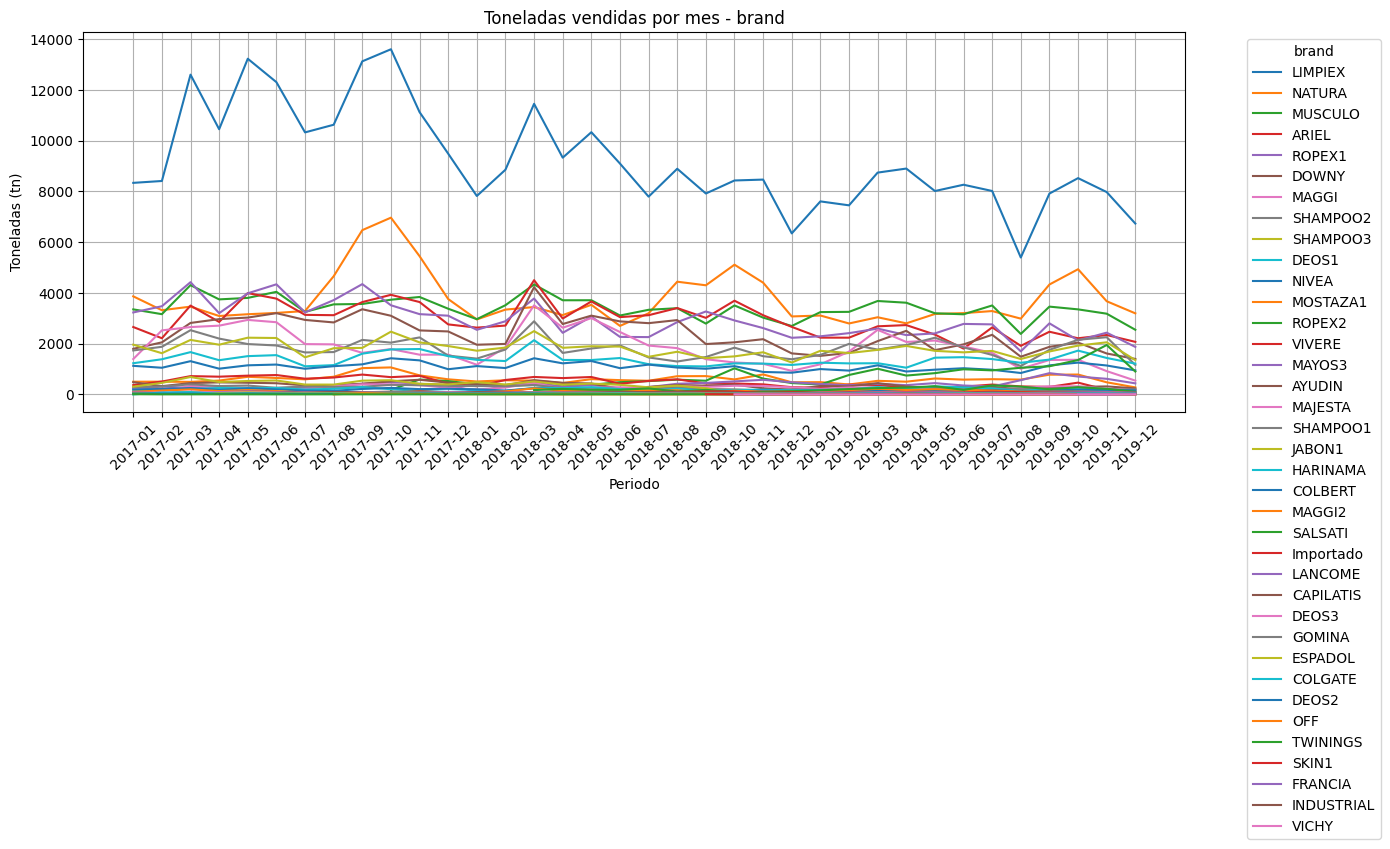

In [28]:
plot_tn_by_category(df, 'brand')

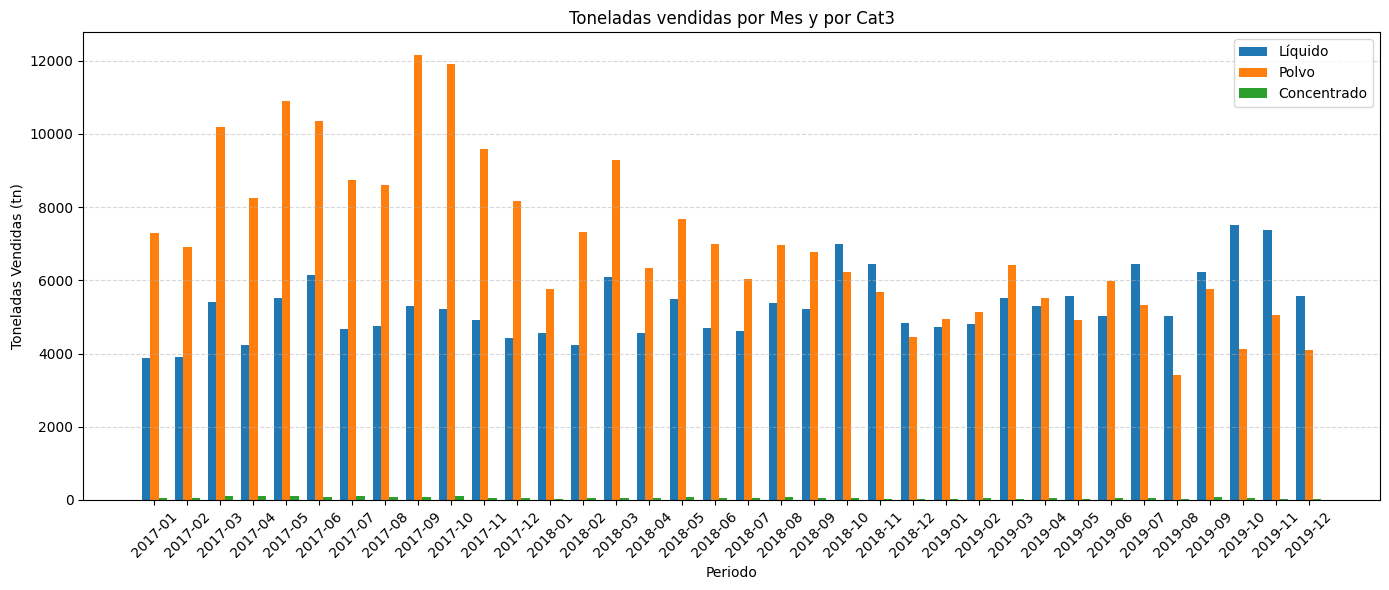

In [20]:
# 2. Hacer pivot table
pivot = df.pivot_table(
    index='periodo',
    columns='cat3',
    values='tn',
    aggfunc='sum'
).reindex(columns=['Liquido', 'Polvo', 'Concentrado'], fill_value=0)

# --- Aquí forzamos que el índice sea datetime ---
pivot.index = pd.to_datetime(pivot.index)

# 3. Preparar posiciones en X
n = len(pivot)
ind = np.arange(n)
width = 0.25

# 4. Dibujar las barras
fig, ax = plt.subplots(figsize=(14,6))
ax.bar(ind - width,    pivot['Liquido'],    width, label='Líquido')
ax.bar(ind,            pivot['Polvo'],      width, label='Polvo')
ax.bar(ind + width,    pivot['Concentrado'],width, label='Concentrado')

# 5. Etiquetas
ax.set_title('Toneladas vendidas por Mes y por Cat3')
ax.set_xlabel('Periodo')
ax.set_ylabel('Toneladas Vendidas (tn)')

# Ahora sí podemos usar .strftime en cada fecha
ax.set_xticks(ind)
ax.set_xticklabels(pivot.index.strftime("%Y-%m"), rotation=45)

ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



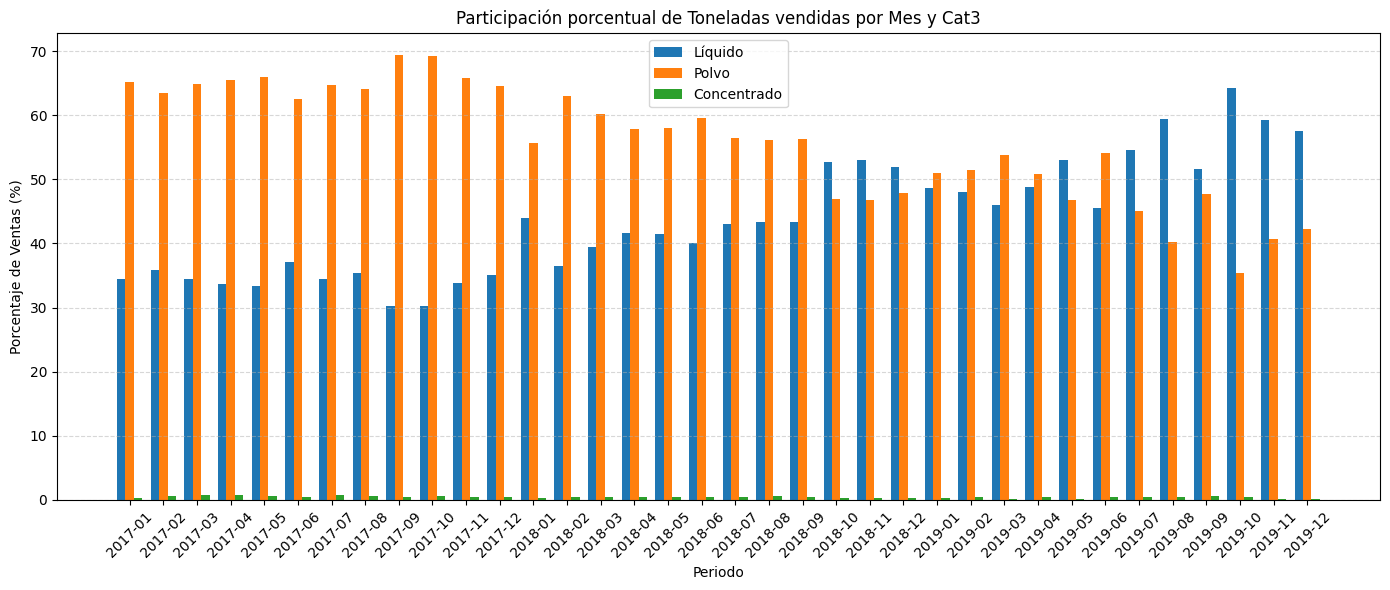

In [22]:
# 3. Convertir a porcentaje de cada mes
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

# 4. Prepara posiciones X
n = len(pivot_pct)
ind = np.arange(n)
width = 0.25

# 5. Gráfico de barras porcentuales
fig, ax = plt.subplots(figsize=(14,6))
ax.bar(ind - width,     pivot_pct['Liquido'],     width, label='Líquido')
ax.bar(ind,             pivot_pct['Polvo'],       width, label='Polvo')
ax.bar(ind + width,     pivot_pct['Concentrado'], width, label='Concentrado')

# 6. Etiquetas y formato
ax.set_title('Participación porcentual de Toneladas vendidas por Mes y Cat3')
ax.set_xlabel('Periodo')
ax.set_ylabel('Porcentaje de Ventas (%)')
ax.set_xticks(ind)
ax.set_xticklabels(pivot_pct.index.strftime("%Y-%m"), rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

 Tenes que bucear en jabón líquido Y ver cuál es el id product que crece
(Seguramente a él concentrado)

In [29]:
# Comparar plan precios cuidados
group_plan = df.groupby('plan_precios_cuidados')['tn'].describe()
group_plan

,count,mean,std,min,25%,50%,75%,max
plan_precios_cuidados,,,,,,,,
0,2911789.0,0.451608,3.119397,0.00010,0.01039,0.03972,0.15834,547.87849
1,34029.0,0.293893,1.937402,0.00022,0.00691,0.02725,0.10592,170.77765


### 7. Generación del Target

In [6]:
# 1. Ordena antes de agrupar
df = df.sort_values(['product_id','periodo'])

# 2. Dentro de cada producto, desplaza 'tn' dos filas hacia arriba
df['tn_target'] = df.groupby('product_id')['tn'].shift(-2)
df.head()
# 3. Si solo quieres las filas que efectivamente tengan target
#df_with_target = df.dropna(subset=['tn_target'])
#print(df_with_target.shape)


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,stock_final,tn_target
44019,2017-01,10001,20001,0,11,99.43861,99.43861,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN,0.24625
44020,2017-01,10063,20001,0,1,0.12312,0.12312,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN,1.23123
44021,2017-01,10080,20001,0,1,0.24625,0.24625,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN,0.06716
44022,2017-01,10094,20001,0,1,1.23123,1.23123,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN,0.05596
44023,2017-01,10184,20001,0,1,0.06716,0.06716,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN,0.61562


In [8]:
print(df['periodo'].dtypes)

object


In [25]:
# Asegurarse que periodo esté en datetime
#df['periodo'] = pd.to_datetime(df['periodo'], format='%Y-%m')
df['periodo'] = pd.to_datetime(df['periodo'], errors='coerce', format='%Y-%m')

In [9]:
df['periodo'] = pd.to_datetime(df['periodo'], errors='coerce', format='%Y-%m')
print(df['periodo'].isna().sum(), "fechas no parseadas")

0 fechas no parseadas


In [10]:
df_target = df[['product_id', 'periodo', 'tn']].copy()
df_target['periodo'] -= pd.DateOffset(months=2)
df_target = df_target.rename(columns={'tn': 'tn_target'})
print(df_target.shape)
print("Duplicados en clave:", df_target.duplicated(['product_id','periodo']).sum())

(2945818, 3)
Duplicados en clave: 2914575


In [11]:
df_target.head()

,product_id,periodo,tn_target
0,20524,2016-11-01,0.05300
1,20524,2016-11-01,0.13628
2,20524,2016-11-01,0.03028
3,20524,2016-11-01,0.02271
4,20524,2016-11-01,1.54452


In [12]:
# # Unir el target al dataset original
# df_with_target = df.merge(df_target, on=['product_id', 'periodo'], how='left')

: 

In [26]:
# # Crear una copia del dataset con el target desplazado 2 meses hacia atrás
# df_target = df[['product_id', 'periodo', 'tn']].copy()
# df_target['periodo'] = df_target['periodo'] - pd.DateOffset(months=2)
# df_target = df_target.rename(columns={'tn': 'tn_target'})

# # Unir el target al dataset original
# df_with_target = df.merge(df_target, on=['product_id', 'periodo'], how='left')

# df_with_target.shape

: 

In [7]:
# df.memory_usage(deep=True).sum()

1167882650

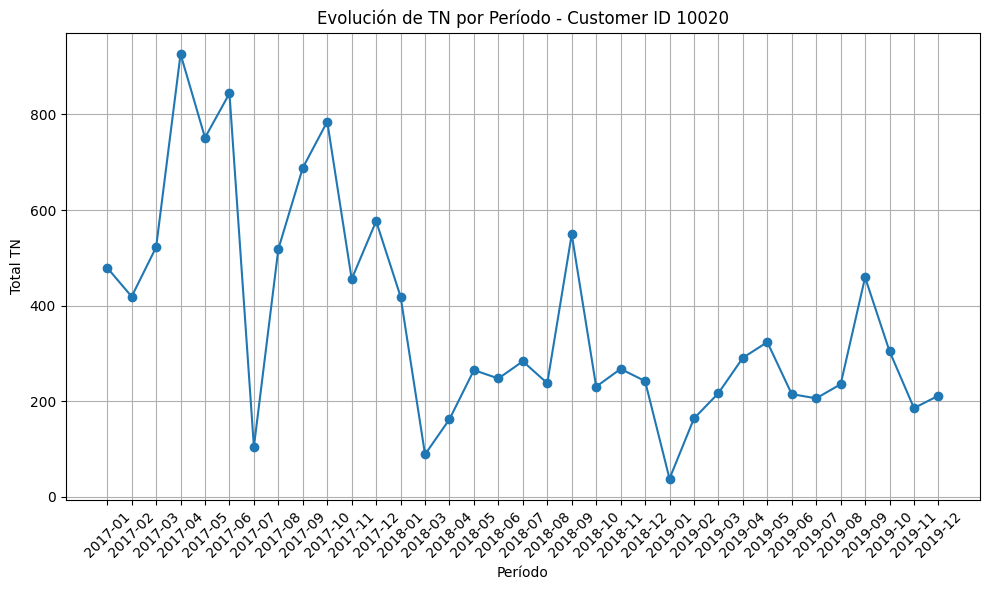

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que ya tienes un DataFrame 'df' con los datos
df_filtered = df[df['customer_id'] == 10020]
df_summary = df_filtered.groupby('periodo')['tn'].sum().reset_index()
df_summary = df_summary.sort_values(by='periodo')

# Graficar
plt.figure(figsize=(10,6))
plt.plot(df_summary['periodo'], df_summary['tn'], marker='o', linestyle='-')
plt.title('Evolución de TN por Período - Customer ID 10020')
plt.xlabel('Período')
plt.ylabel('Total TN')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Cosas a tener en cuenta en el modelo

- Productos discontinuos 
- inserto cero : considerar fecha en que se lanza el producto y fecha en la que se incorpora un cliente
    - customers nuevos --> que hacemos en las fechas previas
    - productos nuevos --> que hacemos en las fechas previas
- Probar Predicción cliente producto y luego sumo todos los tn 
- clientes estrella 20001 20013

In [42]:
import pandas as pd

# Asumo que ya tienes df con columnas: periodo (YYYY-MM como str), customer_id, product_id, tn

# Convertir periodo a PeriodIndex
df['period'] = pd.to_datetime(df['periodo'], format='%Y%m').dt.to_period('M')

# 1.a. Para cada producto: primer y último mes con venta
prod_windows = (
    df.groupby('product_id')['period']
      .agg(first_sale='min', last_sale='max')
      .reset_index()
)

# 1.b. Para cada cliente: primer y último mes con venta
cust_windows = (
    df.groupby('customer_id')['period']
      .agg(first_purchase='min', last_purchase='max')
      .reset_index()
)


In [43]:
from itertools import product

# Lista de todos los product–customer que alguna vez tuvieron venta
pairs = df[['product_id','customer_id']].drop_duplicates()

rows = []
for _, (pid, cid) in pairs.iterrows():
    # Ventanas
    p_start, p_end = prod_windows.loc[prod_windows.product_id==pid, ['first_sale','last_sale']].iloc[0]
    c_start, c_end = cust_windows.loc[cust_windows.customer_id==cid, ['first_purchase','last_purchase']].iloc[0]
    
    # Intersección de períodos en que ambos están “vivos”
    start = max(p_start, c_start)
    end   = min(p_end,   c_end)
    
    # Si la intersección existe
    if start <= end:
        # Generar todos los months entre start y end
        for per in pd.period_range(start, end, freq='M'):
            rows.append((per, pid, cid))

# DataFrame de todos los combos vivos
df_full = pd.DataFrame(rows, columns=['period','product_id','customer_id'])


In [44]:
df_full.shape

(9995676, 3)

In [45]:
# Unir a las ventas reales
df_merge = (
    df_full
    .merge(df[['period','product_id','customer_id','tn']], 
           on=['period','product_id','customer_id'], 
           how='left')
)

# Rellenar NAs como tn=0
df_merge['tn'] = df_merge['tn'].fillna(0)
df_merge.shape

(9995676, 4)

In [7]:
import pandas as pd

# --- Paso 0: Datos de ejemplo cargados ---
# df: columnas ['periodo','customer_id','product_id','tn']
# 'periodo' como string 'YYYY-MM' o 'YYYYMM'

# Convierte a PeriodIndex
df['period'] = pd.to_datetime(df['periodo'], format='%Y-%m').dt.to_period('M')

# --- Paso 1: Ventanas de existencia ---

# Para cada producto: primer y último mes con venta
prod_win = (
    df.groupby('product_id')['period']
      .agg(first_sale='min', last_sale='max')
      .reset_index()
)

# Para cada cliente: primer y último mes con venta
cust_win = (
    df.groupby('customer_id')['period']
      .agg(first_purchase='min', last_purchase='max')
      .reset_index()
)

# --- Paso 2: Rango completo de meses y listados únicos ---

all_periods = pd.period_range(df['period'].min(), df['period'].max(), freq='M')
all_products = df['product_id'].unique()
all_customers = df['customer_id'].unique()

# --- Paso 3: Cartesian product de (periodo × producto × cliente) ---

full = (
    pd.MultiIndex
      .from_product([all_periods, all_products, all_customers],
                    names=['period','product_id','customer_id'])
      .to_frame(index=False)
)

# --- Paso 4: Asigno ventanas de existencia a cada fila ---

# Merge las ventanas
full = (
    full
    .merge(prod_win, on='product_id', how='left')
    .merge(cust_win, on='customer_id', how='left')
)

# Marco alive = periodo dentro de ambas ventanas
full['alive'] = (
    (full['period'] >= full['first_sale']) &
    (full['period'] <= full['last_sale']) &
    (full['period'] >= full['first_purchase']) &
    (full['period'] <= full['last_purchase'])
)

# --- Paso 5: Uno con las ventas reales ---

full = full.merge(
    df[['period','product_id','customer_id','tn']],
    on=['period','product_id','customer_id'],
    how='left'
)

# --- Paso 6: Asigno tn según alive y merge ---

# 1) Fuera de alive → NA
full.loc[~full['alive'], 'tn'] = pd.NA

# 2) Dentro de alive & tn isna → 0 (no compró)
mask = full['alive'] & full['tn'].isna()
full.loc[mask, 'tn'] = 0

# Las demás (alive & tn notna) mantienen el valor real.

# --- Resultado ---
result = full[['period','product_id','customer_id','tn']]
# Si querés volver a string YYYY-MM:
result['periodo'] = result['period'].dt.strftime('%Y-%m')

print(result.head(10))
print(f"Total filas: {len(result)}")
print(f"Alive con ventas:   {((full['alive']) & full['tn']>0).sum()}")
print(f"Alive sin ventas:   {(mask).sum()}")
print(f"No alive (NA tn):  {(~full['alive']).sum()}")


/var/folders/c5/g8wp4j8j1nd226rj0lw9_vz40000gn/T/ipykernel_94437/2610934330.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['periodo'] = result['period'].dt.strftime('%Y-%m')


    period  product_id  customer_id       tn  periodo
0  2017-01       20524        10234  0.05300  2017-01
1  2017-01       20524        10032  0.13628  2017-01
2  2017-01       20524        10217  0.03028  2017-01
3  2017-01       20524        10125  0.02271  2017-01
4  2017-01       20524        10012  1.54452  2017-01
5  2017-01       20524        10080  0.01514  2017-01
6  2017-01       20524        10015  0.10600  2017-01
7  2017-01       20524        10062  0.18928  2017-01
8  2017-01       20524        10159  0.02271  2017-01
9  2017-01       20524        10183  0.01514  2017-01
Total filas: 26499636
Alive con ventas:   2945818
Alive sin ventas:   12617295
No alive (NA tn):  10936523


In [8]:
import pandas as pd

# 1. Carga tu listado de productos (puede ser .csv, .txt, .xlsx, etc.)
#    Asegurate de que 'product_id' sea la columna correcta.
df_productos_keep = pd.read_csv('product_id_apredecir201912.txt')  # o .csv, .xlsx, según tu caso

# 2. Filtra el DataFrame 'result' usando esa columna
result_filtrado = result[result['product_id'].isin(df_productos_keep['product_id'])]

# 3. Verifica
print(f"Filas tras filtrar: {len(result_filtrado)}")
print("Productos retenidos:", result_filtrado['product_id'].unique())


Filas tras filtrar: 16763760
Productos retenidos: [20524 20311 20654 20828 20941 20803 20781 20313 20224 20232 20158 21048
 20086 20852 20948 20283 20937 21080 20947 20812 20970 20609 20051 20242
 20325 20033 21088 20432 20424 20505 20484 20641 20721 20660 20925 21032
 20730 20388 20119 20129 20053 20846 20007 20055 20810 20672 20148 20233
 20162 20366 20482 20606 20745 20579 20713 20470 20596 20824 20039 20082
 20361 20322 20207 20281 20120 20132 20353 20111 20605 20276 20701 20864
 20076 20744 20253 20027 20068 20549 20708 20463 20570 20714 20661 20693
 20538 20922 20786 20466 20532 20380 20438 20404 20117 20680 20407 20285
 20936 20346 20372 20381 20352 20005 20004 20003 20379 20019 20800 20411
 20272 20617 20057 20052 20384 20108 20118 20046 20142 20240 20259 20565
 20396 20892 20125 20139 20093 20101 20106 20123 20894 20879 20077 20269
 20383 20277 20006 20017 20029 20097 20109 20099 20013 20092 20065 20205
 20166 20137 20008 20018 20096 20761 20705 20087 20074 20644 20676 20517
 

In [17]:
result_filtrado[result_filtrado['tn'].isna() == True].head()

,period,product_id,customer_id,tn,periodo
433,2017-01,20524,10312,NaN,2017-01
434,2017-01,20524,10505,NaN,2017-01
435,2017-01,20524,10367,NaN,2017-01
436,2017-01,20524,10363,NaN,2017-01
437,2017-01,20524,10506,NaN,2017-01


In [16]:
df[(df['product_id'] == 20524) & (df['customer_id'] == 10587) & (df['periodo'] == '2019-12')]

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,stock_final,period


In [18]:
result_filtrado[result_filtrado['tn'] == 0].shape

(8740884, 5)

In [19]:
result_filtrado[result_filtrado['tn'].isna() == True].shape

(5729395, 5)

In [20]:
result_filtrado[result_filtrado['tn'] > 0].shape

(2293481, 5)

In [ ]:
# 1. Carga el listado de product_id desde el .txt
with open('product_id_apredecir201912.txt', 'r') as f:
    productos_keep = [line.strip() for line in f if line.strip()]

# Si los IDs son enteros, convertí el tipo (opcional)
# productos_keep = [int(x) for x in productos_keep]

# 2. Filtra tu DataFrame `result`
result_filtrado = result[result['product_id'].isin(productos_keep)]

# 3. Verifica
print(f"Filas totales tras filtrar: {len(result_filtrado)}")
print(result_filtrado['product_id'].unique())
